In [128]:
import ortools
from ortools.constraint_solver import routing_enums_pb2
import ortools.constraint_solver.pywrapcp as pywrapcp
from PIL import Image
from IPython.display import display
import pandas as pd
from itertools import zip_longest
from geopy.distance import geodesic


import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [129]:
teste = pd.read_excel(r"ara_adm (1).xlsx")

In [130]:
teste 

,qtd,lat,long
0,0,-19.837913,-40.082170
1,5,-19.903273,-40.232890
2,2,-19.904354,-40.223015
3,2,-19.920553,-40.174908
4,2,-19.927172,-40.164630
...,...,...,...
138,5,-20.261312,-40.263690
139,3,-20.257410,-40.263832
140,2,-20.250269,-40.265118
141,1,-20.214258,-40.263565


In [131]:
teste['lat'] = teste['lat'].astype(str)
teste['long'] = teste['long'].astype(str)
teste['lat'] = teste['lat'].str.replace(",",".")
teste['long'] = teste['long'].str.replace(",",".")
teste['lat'] = teste['lat'].astype(float)
teste['long'] = teste['long'].astype(float)
teste['qtd'] = teste['qtd'].astype(int)

In [132]:
x = list(zip_longest(teste['lat'], teste['long'], fillvalue=None))

# Criação da matriz de distancia

In [133]:
# Crie uma matriz de distância vazia
distance_matrix = []

# Calcule as distâncias entre todos os pares de coordenadas
for coord1 in x:
    distances = []
    for coord2 in x:
        distancia = geodesic(coord1, coord2).kilometers
        distances.append(distancia)
    distance_matrix.append(distances)

# Imprima a matriz de distância
# for i, row in enumerate(distance_matrix):
#     for j, distancia in enumerate(row):
#         print(f"Distância entre cidade {i} e cidade {j}: {distancia} km")


In [134]:
# distance_matrix

# Seleção dos pontos segundo a regiao e a distancia

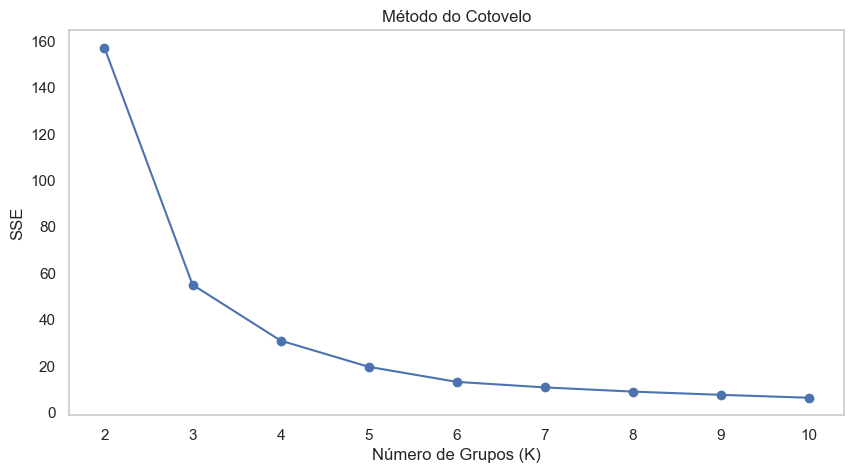

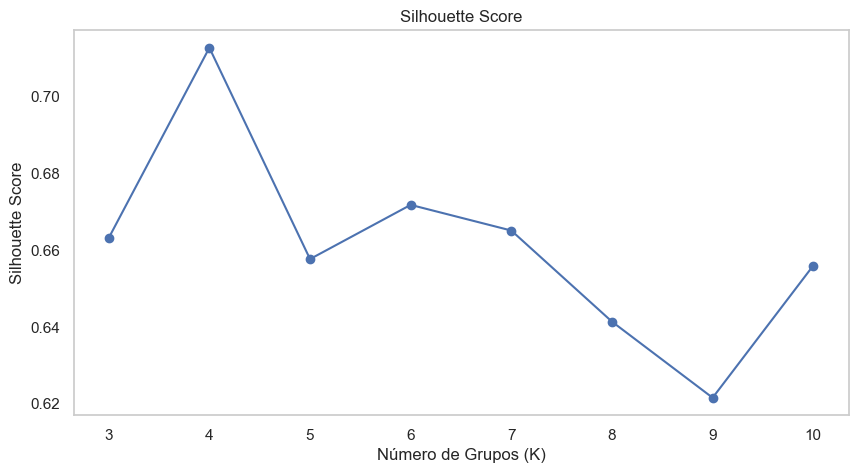

In [135]:
def find_optimal_k(data_frame, max_k=10):
    # Selecionar as colunas 'lat' e 'long'
    features = data_frame[['lat', 'long']]

    # Padronizar as features para média zero e desvio padrão 1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Inicializar listas para guardar os valores do SSE (Erro Quadrático Médio) e silhouette_score
    sse = []
    silhouette_scores = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(scaled_features)

        # Calcular o SSE
        sse.append(kmeans.inertia_)

        # Calcular o silhouette_score para avaliação
        if k > 2:
            silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

    # Plotar o gráfico do SSE para o método do cotovelo
    plt.figure(figsize=(10, 5))
    plt.plot(range(2, max_k + 1), sse, marker='o')
    plt.title('Método do Cotovelo')
    plt.xlabel('Número de Grupos (K)')
    plt.ylabel('SSE')
    plt.grid()
    plt.show()

    # Plotar o gráfico do silhouette_score
    plt.figure(figsize=(10, 5))
    plt.plot(range(3, max_k + 1), silhouette_scores, marker='o')
    plt.title('Silhouette Score')
    plt.xlabel('Número de Grupos (K)')
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

# Exemplo de uso da função
if __name__ == "__main__":
    # Carregar seu DataFrame pandas com as colunas 'lat' e 'long'
    # df = pd.read_csv('seuarquivo.csv')

    # Chamando a função para encontrar o número ideal de grupos
    find_optimal_k(teste[1:])

In [136]:
def cluster_data(data_frame, n_clusters):
    # Selecionar as colunas 'lat' e 'long'
    features = data_frame[['lat', 'long']]

    # Padronizar as features para média zero e desvio padrão 1
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Executar o algoritmo K-Means com o número de grupos especificado
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    data_frame['cluster'] = kmeans.fit_predict(scaled_features)

    return data_frame

# Exemplo de uso da função
if __name__ == "__main__":
    # Carregar seu DataFrame pandas com as colunas 'lat' e 'long'
    # df = pd.read_csv('seuarquivo.csv')

    # Especificar o número desejado de grupos (n)
    n = 16
    n_clusters = int(n**(1/2)+1)

    # Chamar a função para agrupar os dados em n grupos
    clustered_df = cluster_data(teste[1:], n_clusters)

    # O DataFrame 'clustered_df' agora terá uma nova coluna 'cluster' com os rótulos de grupo


In [137]:
clustered_df = clustered_df.assign(row=1)
clustered_df

,qtd,lat,long,cluster,row
1,5,-19.903273,-40.232890,1,1
2,2,-19.904354,-40.223015,1,1
3,2,-19.920553,-40.174908,3,1
4,2,-19.927172,-40.164630,3,1
5,3,-19.930769,-40.152954,3,1
...,...,...,...,...,...
138,5,-20.261312,-40.263690,0,1
139,3,-20.257410,-40.263832,0,1
140,2,-20.250269,-40.265118,0,1
141,1,-20.214258,-40.263565,0,1


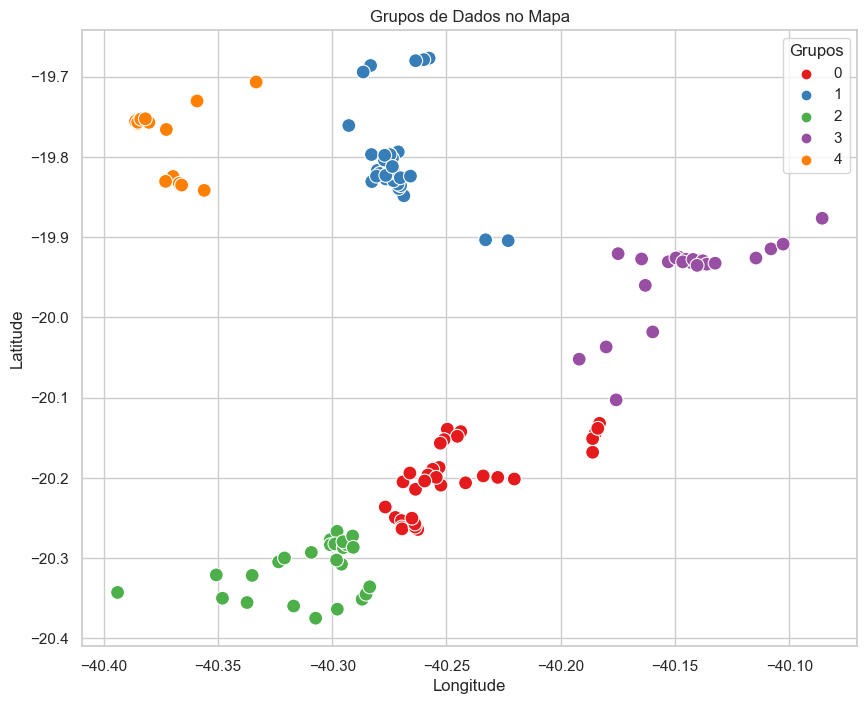

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters_on_map(data_frame, lat_col, long_col, cluster_col):
    # Extrair as coordenadas de latitude e longitude e os rótulos de grupo
    lats = data_frame[lat_col]
    longs = data_frame[long_col]
    clusters = data_frame[cluster_col]

    # Configurar o estilo do gráfico de dispersão
    sns.set(style='whitegrid')
    plt.figure(figsize=(10, 8))

    # Plotar os pontos coloridos por grupo
    sns.scatterplot(x=longs, y=lats, hue=clusters, palette='Set1', s=100, legend='full')

    # Configurar rótulos e título
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Grupos de Dados no Mapa')

    # Mostrar a legenda
    plt.legend(title='Grupos', loc='upper right')

    # Exibir o mapa
    plt.show()

# Exemplo de uso da função
if __name__ == "__main__":
    # Carregar seu DataFrame pandas com as colunas 'lat', 'long', e 'cluster'
    # df = pd.read_csv('seuarquivo.csv')

    # Chamar a função para plotar os grupos no mapa
    plot_clusters_on_map(clustered_df, 'lat', 'long', 'cluster')


# Seleção dos pontos de start
## Criterios
demanda na regiao
distancia
numero de linhas desejadas pelo usuario

In [139]:
clustered_df.columns

Index(['qtd', 'lat', 'long', 'cluster', 'row'], dtype='object')

In [140]:
clustered_df[['cluster', 'qtd', 'row']].groupby('cluster').sum(['qtd', 'row']).sort_values('qtd', ascending=False)

,qtd,row
cluster,,
1,329,43
4,130,16
0,74,32
3,64,26
2,40,25


## Possiveis melhores inicios de rotas baseado nos pontos mais extremos de cada cluster de pontos

1
     Latitude  Longitude Direction
46 -19.676890 -40.257600     North
2  -19.904354 -40.223015     South
2  -19.904354 -40.223015      East
51 -19.760822 -40.292744      West


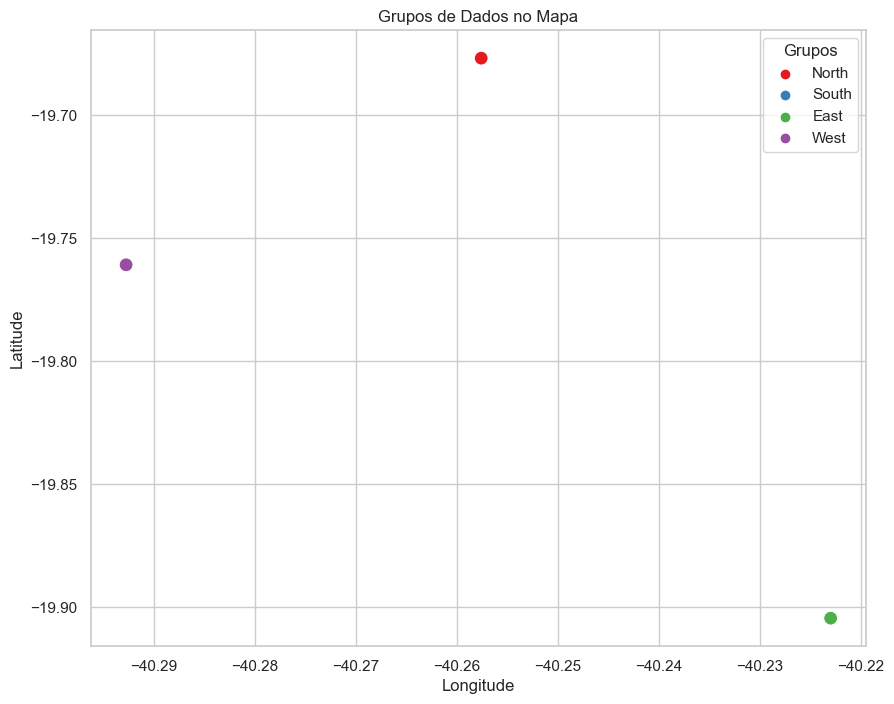


3
      Latitude  Longitude Direction
23  -19.876421 -40.085630     North
94  -20.102810 -40.175774     South
23  -19.876421 -40.085630      East
129 -20.052052 -40.191940      West


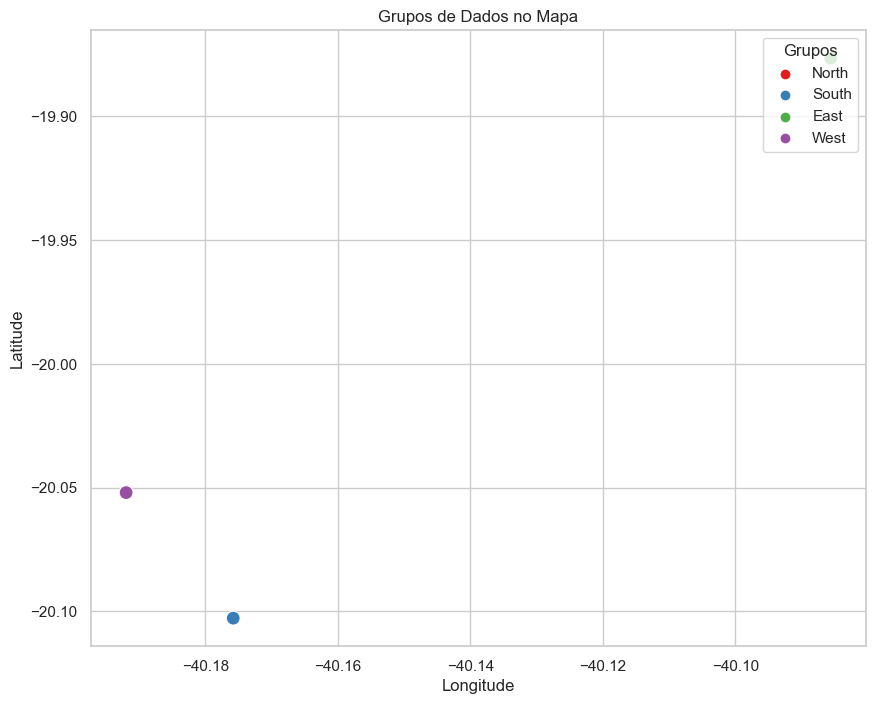


4
     Latitude  Longitude Direction
45 -19.706594 -40.333290     North
75 -19.841650 -40.356020     South
45 -19.706594 -40.333290      East
59 -19.755531 -40.386074      West


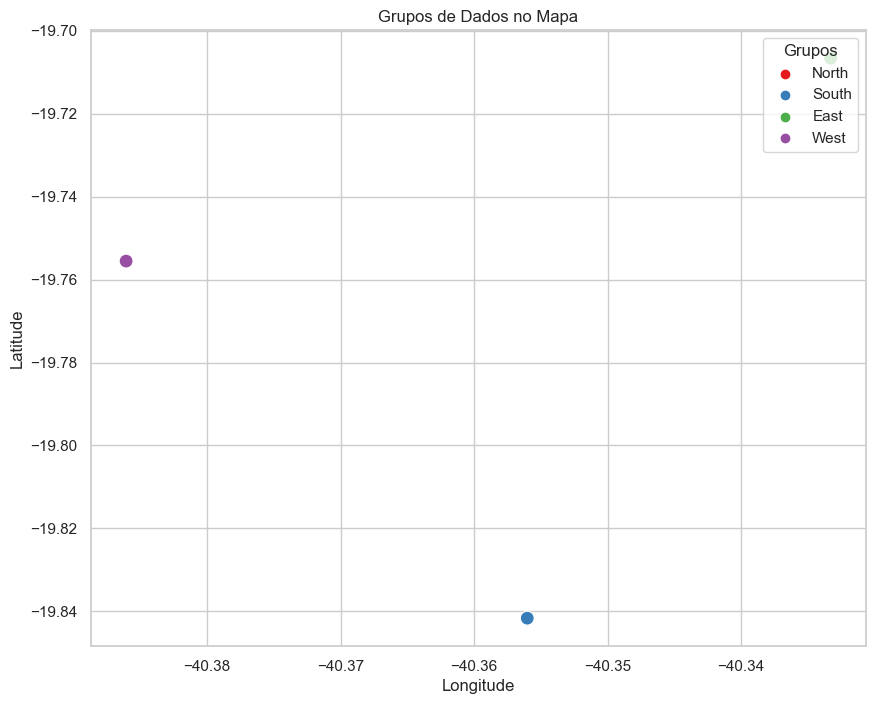


2
     Latitude  Longitude Direction
90 -20.266634 -40.297882     North
82 -20.374887 -40.307243     South
86 -20.335823 -40.283580      East
95 -20.342820 -40.393913      West


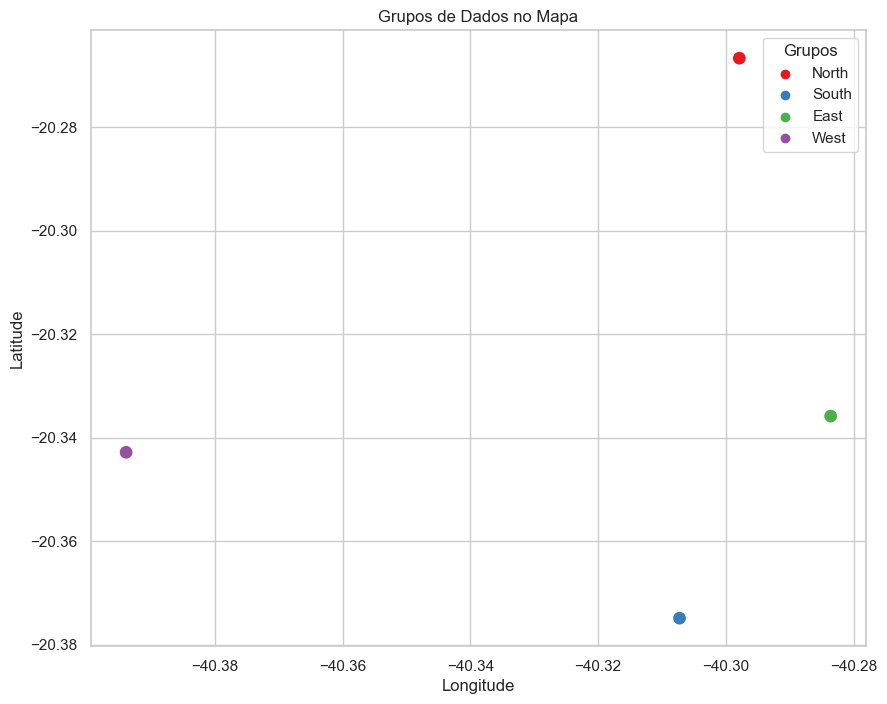


0
      Latitude  Longitude Direction
106 -20.132030 -40.183033     North
137 -20.264362 -40.262580     South
106 -20.132030 -40.183033      East
112 -20.236338 -40.276800      West


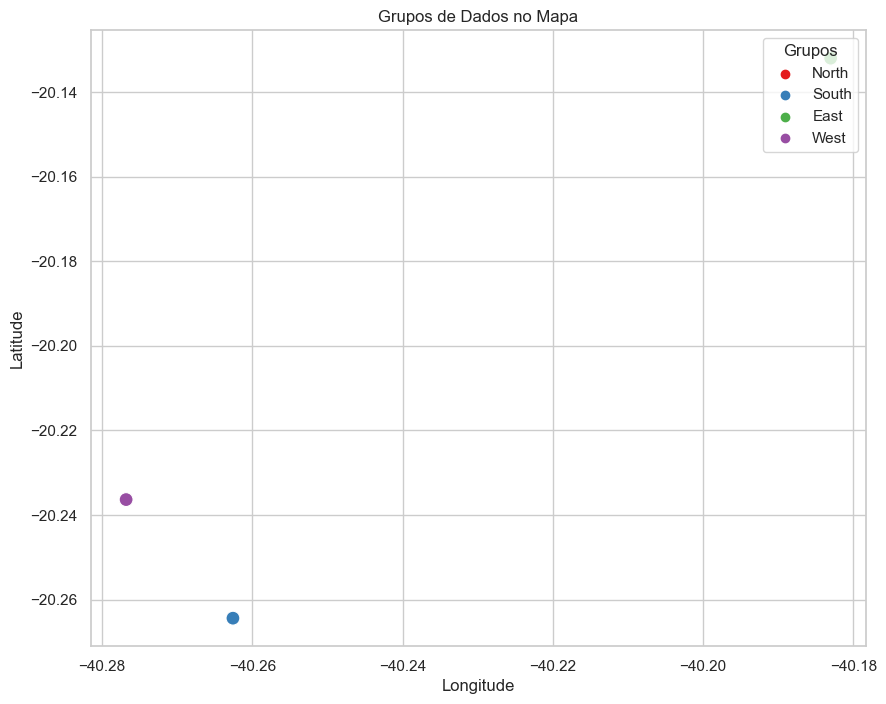

In [141]:
def find_extreme_points_with_direction(latitudes, longitudes):
    # Criar um DataFrame a partir das listas de latitudes e longitudes
    data = pd.DataFrame({'Latitude': latitudes, 'Longitude': longitudes})

    # Encontrar o ponto mais ao norte
    northernmost_point = data[data['Latitude'] == max(data['Latitude'])]
    northernmost_point['Direction'] = 'North'

    # Encontrar o ponto mais ao sul
    southernmost_point = data[data['Latitude'] == min(data['Latitude'])]
    southernmost_point['Direction'] = 'South'

    # Encontrar o ponto mais a leste
    easternmost_point = data[data['Longitude'] == max(data['Longitude'])]
    easternmost_point['Direction'] = 'East'

    # Encontrar o ponto mais a oeste
    westernmost_point = data[data['Longitude'] == min(data['Longitude'])]
    westernmost_point['Direction'] = 'West'

    # Combinar os pontos extremos em um único DataFrame
    extreme_points = pd.concat([northernmost_point, southernmost_point, easternmost_point, westernmost_point])

    return extreme_points

# Exemplo de uso da função
if __name__ == "__main__":
    for cluster in clustered_df['cluster'].unique():
        print(cluster)
        # Lista de latitudes e longitudes
        latitudes = clustered_df[clustered_df['cluster']==cluster]['lat']  # Substitua pelos valores reais
        longitudes = clustered_df[clustered_df['cluster']==cluster]['long']  # Substitua pelos valores reais

        # Chamar a função para encontrar os pontos extremos e criar um DataFrame
        extreme_coordinates_df = find_extreme_points_with_direction(latitudes, longitudes)

        # Exibir o DataFrame com os resultados
        print(extreme_coordinates_df)
        # Chamar a função para plotar os grupos no mapa
        plot_clusters_on_map(extreme_coordinates_df, 'Latitude', 'Longitude', 'Direction')
        print()

No grupo 0, existe uma demanda de 329 lugares e cerca de 43 paradas

In [142]:
import math

def calculate_distance(lat1, long1, lat2, long2):
    # Função para calcular a distância entre dois pontos usando a fórmula Haversine
    earth_radius_km = 6371.0  # Raio médio da Terra em quilômetros

    # Converter as coordenadas de graus para radianos
    lat1 = math.radians(lat1)
    long1 = math.radians(long1)
    lat2 = math.radians(lat2)
    long2 = math.radians(long2)

    # Diferenças de latitude e longitude
    dlat = lat2 - lat1
    dlong = long2 - long1

    # Fórmula de Haversine
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlong / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = earth_radius_km * c

    return distance

def find_best_starting_point(latitudes, longitudes, destination_lat, destination_long):
    # Ponto de destino
    dest = (destination_lat, destination_long)

    # Inicializar variáveis para controlar o melhor ponto de partida
    best_start = None
    best_cost_benefit = float('inf')  # Inicializado com infinito

    # Iterar sobre os pontos de partida e calcular o custo-benefício
    for i in range(len(latitudes)):
        start = (latitudes[i], longitudes[i])
        distance = calculate_distance(latitudes[i], longitudes[i], destination_lat, destination_long)

        # Você pode definir seu próprio critério de custo-benefício aqui
        # Quanto menor o custo-benefício, melhor
        cost_benefit = distance  # Exemplo simples: custo igual à distância

        if cost_benefit < best_cost_benefit:
            best_cost_benefit = cost_benefit
            best_start = start

    return best_start

# Exemplo de uso da função
if __name__ == "__main__":
    # Listas de latitudes e longitudes
    latitudes =  list(clustered_df[clustered_df['cluster']==0]['lat']) # Substitua pelos valores reais
    longitudes = list(clustered_df[clustered_df['cluster']==0]['long'])  # Substitua pelos valores reais

    # Coordenadas do ponto de destino
    destination_lat =  -19.837913 # Substitua pelo valor real
    destination_long = -40.082170  # Substitua pelo valor real

    # Encontrar o melhor ponto de partida
    best_starting_point = find_best_starting_point(latitudes, longitudes, destination_lat, destination_long)

    print(f"Melhor ponto de partida: Latitude {best_starting_point[0]}, Longitude {best_starting_point[1]}")

Melhor ponto de partida: Latitude -20.13203, Longitude -40.183033


In [143]:
# Tetsando o melhor potno de partida para o cluters 0

## Restrições de capacidade

restriçoes de demanda, quantidade de veículos, capacidade dos veiculos

## Rotas ciculares

In [88]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["demands"] = teste['qtd']
    data["vehicle_capacities"] = [46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46, 46]
    data["num_vehicles"] = len(data["vehicle_capacities"])
    data["depot"] = 0
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} Load({route_load}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")

    
def verify_data(data):
    demanda = sum([x for x in data["demands"]])
    lugares = sum([x for x in data["vehicle_capacities"]])
    
    if lugares >= demanda:
        print(f"existem mais lugares que demanda")
        return True
        
    if demanda > lugares:
        print(f"Não existem lugares suficientes \n"
             f"{lugares} -- lugares, {demanda} --  demanda\n")
        return False
    

def main():
    """Solve the CVRP problem."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix)

    x = verify_data(data)
    
    if x == False:
        print(x)
    
    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Capacity constraint.
    def demand_callback(from_index):
        """Returns the demand of the node."""
        # Convert from routing variable Index to demands NodeIndex.
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data["vehicle_capacities"],  # vehicle maximum capacities
        True,  # start cumul to zero
        "Capacity",
    )

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.FromSeconds(1)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == "__main__":
    main()

existem mais lugares que demanda
Objective: 1036
Route for vehicle 0:
 0 Load(0) ->  0 Load(0)
Distance of the route: 0m
Load of the route: 0

Route for vehicle 1:
 0 Load(0) ->  133 Load(5) ->  104 Load(7) ->  90 Load(11) ->  102 Load(12) ->  111 Load(14) ->  101 Load(16) ->  100 Load(18) ->  99 Load(20) ->  89 Load(21) ->  98 Load(22) ->  97 Load(23) ->  96 Load(25) ->  110 Load(26) ->  109 Load(27) ->  95 Load(28) ->  108 Load(29) ->  107 Load(30) ->  81 Load(32) ->  82 Load(33) ->  83 Load(34) ->  84 Load(38) ->  85 Load(39) ->  86 Load(40) ->  88 Load(42) ->  87 Load(44) ->  125 Load(46) ->  0 Load(46)
Distance of the route: 132m
Load of the route: 46

Route for vehicle 2:
 0 Load(0) ->  119 Load(2) ->  121 Load(5) ->  114 Load(11) ->  113 Load(12) ->  91 Load(13) ->  112 Load(17) ->  140 Load(19) ->  139 Load(22) ->  138 Load(27) ->  137 Load(28) ->  136 Load(30) ->  135 Load(32) ->  134 Load(33) ->  103 Load(34) ->  58 Load(46) ->  0 Load(46)
Distance of the route: 141m
Load of 

In [89]:
x = list(zip_longest(teste['lat'], teste['long'], fillvalue=None))

In [90]:
# Crie uma matriz de distância vazia
distance_matrix = []

# Calcule as distâncias entre todos os pares de coordenadas
for coord1 in x:
    distances = []
    for coord2 in x:
        distancia = geodesic(coord1, coord2).kilometers
        distances.append(distancia)
    distance_matrix.append(distances)

# Imprima a matriz de distância
# for i, row in enumerate(distance_matrix):
#     for j, distancia in enumerate(row):
#         print(f"Distância entre cidade {i} e cidade {j}: {distancia} km")


## Rotas em linha

In [91]:
"""Simple Vehicles Routing Problem."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model(distance_matrix):
    """Stores the data for the problem."""
    data = {}
    data["distance_matrix"] = distance_matrix
    data["num_vehicles"] = 9
    data["starts"] = [1, 2, 15, 16, 8, 10, 35, 56, 71]
    data["ends"] = [0, 0, 0, 0, 0, 0, 0, 0, 0]
    return data


def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    max_route_distance = 0
    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += f" {manager.IndexToNode(index)} -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f"{manager.IndexToNode(index)}\n"
        plan_output += f"Distance of the route: {route_distance}m\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}m")


def main():
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model(distance_matrix)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["starts"], data["ends"]
    )

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)

    # Create and register a transit callback.
    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc.
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = "Distance"
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        2000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name,
    )
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution(data, manager, routing, solution)


if __name__ == "__main__":
    main()

Objective: 10780
Route for vehicle 0:
 1 -> 0
Distance of the route: 0m

Route for vehicle 1:
 2 -> 0
Distance of the route: 0m

Route for vehicle 2:
 15 ->  117 ->  116 ->  92 ->  91 ->  90 ->  100 ->  99 ->  97 ->  109 ->  95 ->  110 ->  101 ->  102 ->  103 ->  104 ->  136 ->  137 ->  138 ->  139 ->  140 ->  141 ->  124 ->  122 ->  121 ->  120 ->  119 ->  118 ->  132 ->  14 ->  20 ->  19 ->  13 ->  12 ->  21 ->  22 ->  23 -> 0
Distance of the route: 105m

Route for vehicle 3:
 16 -> 0
Distance of the route: 0m

Route for vehicle 4:
 8 ->  17 ->  11 ->  9 ->  18 ->  131 ->  130 ->  123 ->  114 ->  125 ->  126 ->  142 ->  113 ->  112 ->  89 ->  98 ->  96 ->  108 ->  107 ->  81 ->  82 ->  83 ->  84 ->  85 ->  86 ->  87 ->  88 ->  111 ->  135 ->  134 ->  133 ->  115 ->  105 ->  127 ->  93 ->  128 ->  106 ->  94 ->  129 ->  7 ->  5 ->  6 -> 0
Distance of the route: 104m

Route for vehicle 5:
 10 -> 0
Distance of the route: 0m

Route for vehicle 6:
 35 ->  36 ->  37 ->  25 ->  24 ->  75 ->

### Para 4 rotas

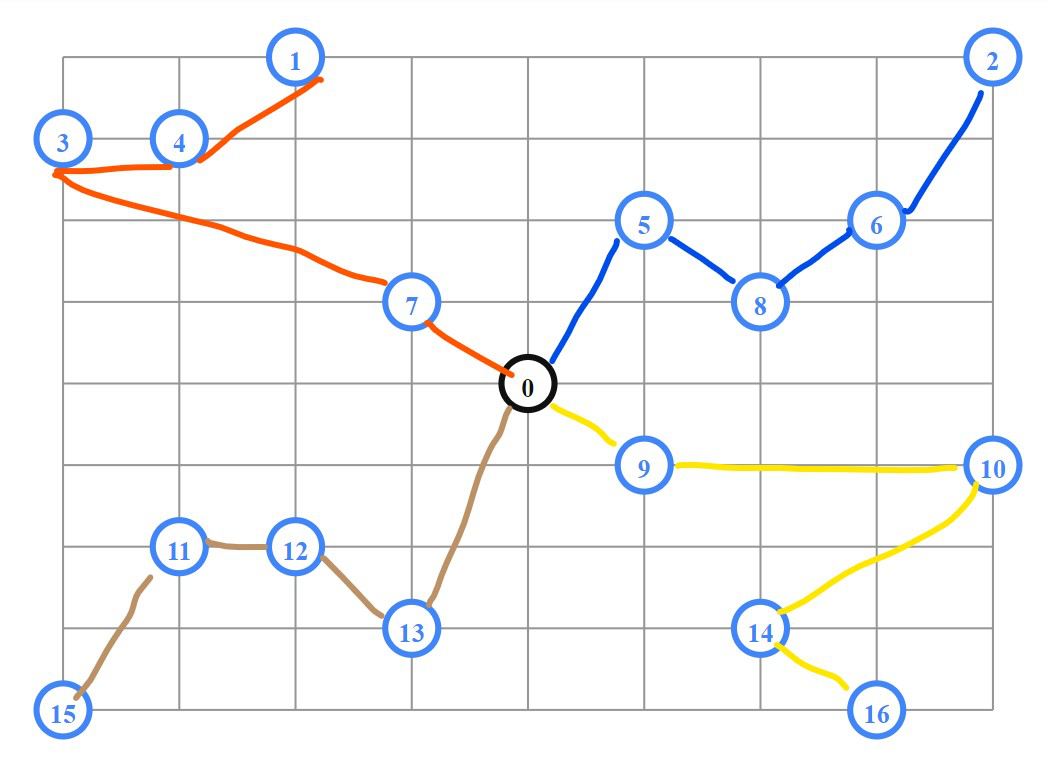

In [92]:
# Abra a imagem
imagem = Image.open("Anotação 2023-11-06 141717.jpg")

# Exiba a imagem no notebook
display(imagem)

### Para 5 rotas

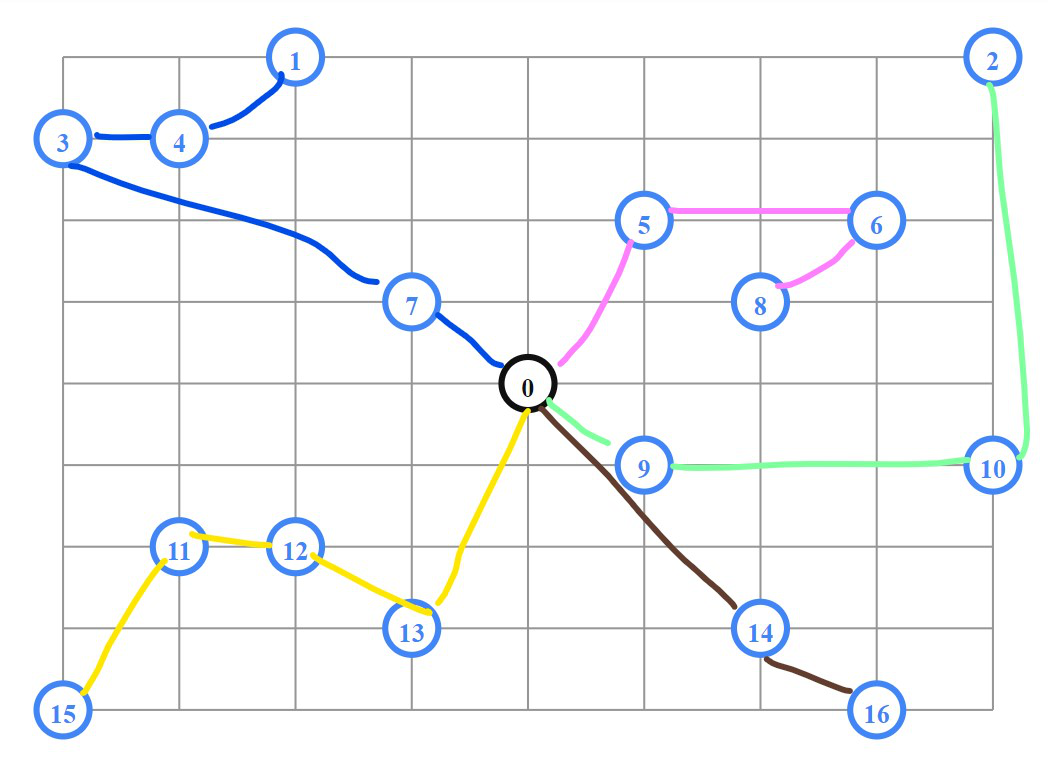

In [93]:
# Abra a imagem
imagem = Image.open("Anotação 2023-11-06 141717 2.jpg")

# Exiba a imagem no notebook
display(imagem)